In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.integrate import cumtrapz
import sys, os, string
from scipy.signal import savgol_filter
import scipy.io as sio
import pickle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from autophasemap import SquareRootSlopeFramework

color_blindf = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", 
"#a96b59", "#e76300", "#b9ac70", "#92dadd"]
bkg_spectra_color = "#717581"

In [3]:
plt_style = {"text.usetex": True,
             "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
             "axes.spines.right" : False,
             "axes.spines.top" : False,
             "font.size": 22,
             "savefig.dpi": 600,
             "savefig.bbox": 'tight'
            }

In [4]:
FGP = sio.loadmat('../../expts/FeGaPd/FeGaPd_full_data_200817a.mat')
C = FGP['C'] # composition
XRD = FGP['X'][:,631:1181] # X-ray diffraction intensities
T = FGP['T'][:,631:1181].squeeze() # 2theta for the XRD intensities
N, n_domain = XRD.shape

n_clusters=5

In [5]:
class DataSet:
    def __init__(self, C, q, Iq, N, n_domain=200):
        """ DataSet object for the XRD case study.

            C  : Composition as a numpy array of (n_samples, 3)
            q : q angle vector of the data as a numpy array of shape (n_domain, )
            Iq : Intensity as a function of q (numpy array of shape (n_samples, n_domain))
            N : Number of samples (int)
            n_domain : Number of samples in the q domain (int)
        """
        self.n_domain = n_domain
        self.t = np.linspace(0,1, num=self.n_domain)
        self.N = N
        self.Iq = Iq
        self.C = C
        self.q = q
        
    def generate(self, normalize=True):
        """Generate data for autophasemap algorithm
        
        normalize : Whetehr to L2-normalize the functional data (bool, default: True)
        """
        if normalize:
            self.F = [self._smoothen(self.Iq[i,:])/self.l2norm(self.Iq[i]) for i in range(N)]
        else:
            self.F = [self.Iq[i,:] for i in range(N)]
            
        return
    
    def _smoothen(self, f):
        """Compute a Savitsky-Golay filtering of the data
        Inputs:
        =======
            f : function values at the discrete sample along the domain
        
        returns:
        ========
            f_hat : Smoothened function values
        """
        f_hat = savgol_filter(f, 51, 3)
        
        return f_hat
    
    def l2norm(self, f):
        """Compute L2-norm of functions
        
        Inputs:
        =======
            f : numpy array of shape (n_domain, )
                function values at the discrete sample along the domain
        
        returns:
        ========
            norm : float 
                Norm of the function
        """
        norm = np.sqrt(np.trapz(f**2, data.t))
        
        return norm

data = DataSet(C, T, XRD, N, n_domain=n_domain)
data.generate(normalize=True)
print('Total number of samples %d'%data.N)

Total number of samples 278


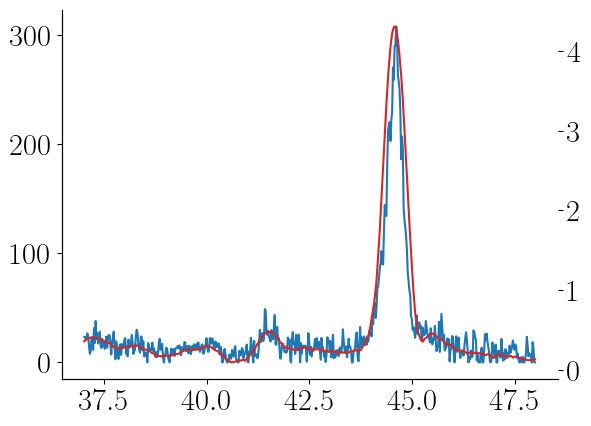

In [12]:
# plot smoothening comparision
with plt.style.context(plt_style):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.plot(data.q, data.Iq[10,:])
    ax2.plot(data.q, data.F[10], color='tab:red')
    plt.show()

In [7]:
# load results from Hyak run
with open('./data.pkl', 'rb') as handle:
    result = pickle.load(handle)

In [8]:
def setup_axs():
    fig = plt.figure(figsize=(5*3, 5*2))
    ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
    ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
    ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
    ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
    ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
    
    axs = [ax1, ax2, ax3, ax4, ax5]
    for k in range(5):
        axs[k].text(0.1, 0.9, r'(%s)'%string.ascii_uppercase[k], 
        transform=axs[k].transAxes, 
        size=20, weight='bold'
        )
    return fig, axs

In [9]:
# plot phase map and corresponding spectra
def cosd(deg):
    # cosine with argument in degrees
    return np.cos(deg * np.pi/180)

def sind(deg):
    # sine with argument in degrees
    return np.sin(deg * np.pi/180)

def tern2cart(T):
    # convert ternary data to cartesian coordinates
    sT = np.sum(T,axis = 1)
    T = 100 * T / np.tile(sT[:,None],(1,3))

    C = np.zeros((T.shape[0],2))
    C[:,1] = T[:,1]*sind(60)/100
    C[:,0] = T[:,0]/100 + C[:,1]*sind(30)/sind(60)
    return C

XYc = tern2cart(C[:,[1,2,0]])
cmap = plt.get_cmap("tab10")

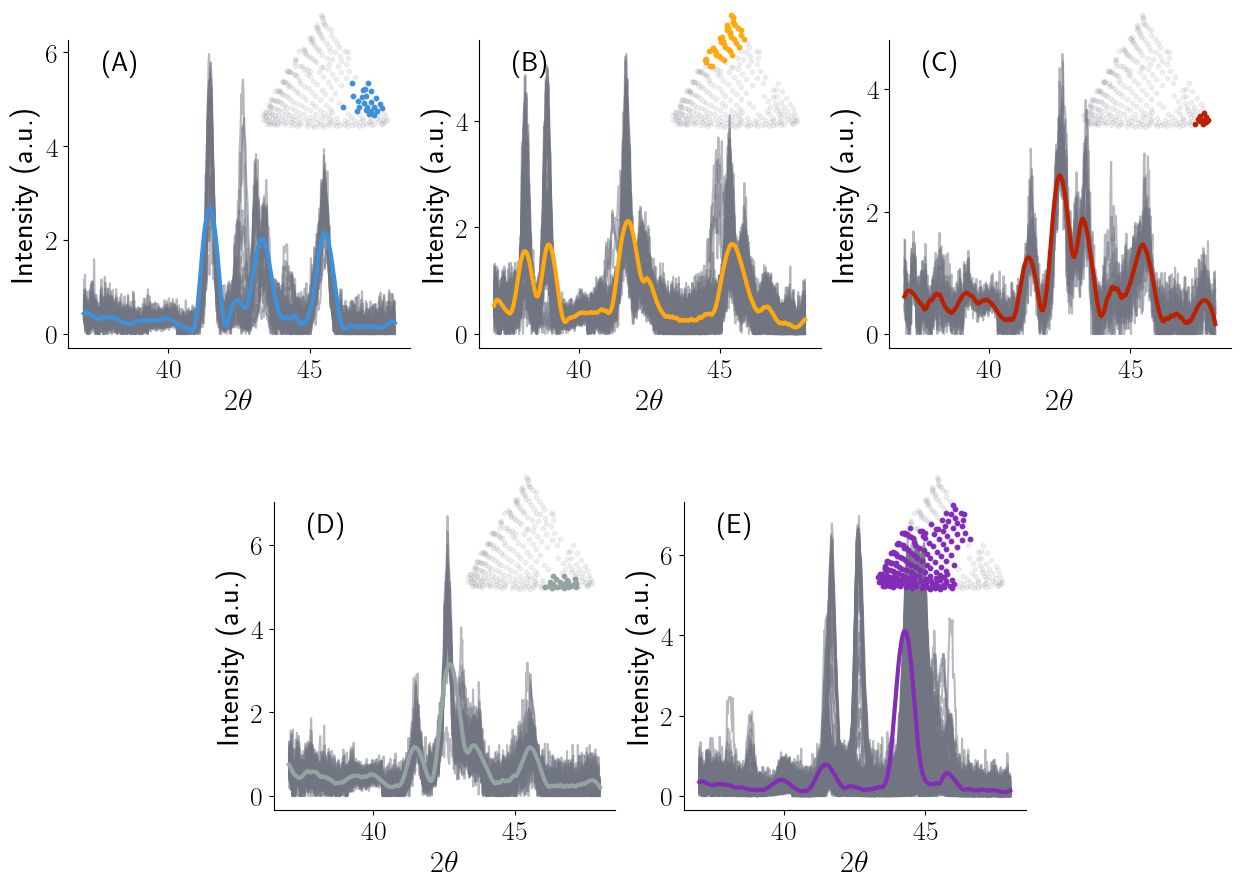

In [10]:
def plot_clusters(axs, data, result, use_aligned=True):
    """ Plot phase map and corresponding spectra.

    axs  : axis handles
    data : DatSet object
    out : Output from the cluster run

    use_aligned : Whether to plot aligned spectra
    """
    bounds = [[0, 0.5], 
          [0, 0.5]
         ]
    labels = result['delta_n']
    n_templates = len(np.unique(labels))
    SRSF = SquareRootSlopeFramework(data.t)

    for k in range(n_templates):
        Mk = np.argwhere(labels==k).squeeze()
        for cs in Mk:
            Iq_query = data.Iq[cs,:]
            Iq_normalized = Iq_query/data.l2norm(Iq_query)
            if use_aligned:
                gamma = result['gam_ik'][cs, k,...]
                spectra = SRSF.warp_f_gamma(Iq_normalized, gamma)
            else:
                spectra = Iq_normalized
                
            axs[k].plot(data.q, spectra, 
                        color=bkg_spectra_color,
                        alpha = 0.5
                       )
            axs[k].set_xlabel(r'$2\theta$', fontsize=22)
            axs[k].set_ylabel(r'Intensity (a.u.)', fontsize=22)
            axs[k].tick_params(labelsize=20)
    
        axs[k].plot(data.q, result['templates'][k], color=color_blindf[k], lw=3.0)
        
        axins = axs[k].inset_axes([0.55, 0.7, 0.4, 0.4])
        axins.scatter(XYc[labels==k,0], XYc[labels==k,1], 
                      color = color_blindf[k],
                      s=10
                     )
        axins.scatter(XYc[labels!=k,0], XYc[labels!=k,1], 
                      color = bkg_spectra_color,
                      alpha = 0.1,
                      s=10
                     )        
        axins.axis('off')
        
    return

with plt.style.context(plt_style):
    fig, axs = setup_axs()
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    plot_clusters(axs, data, result, use_aligned=False)

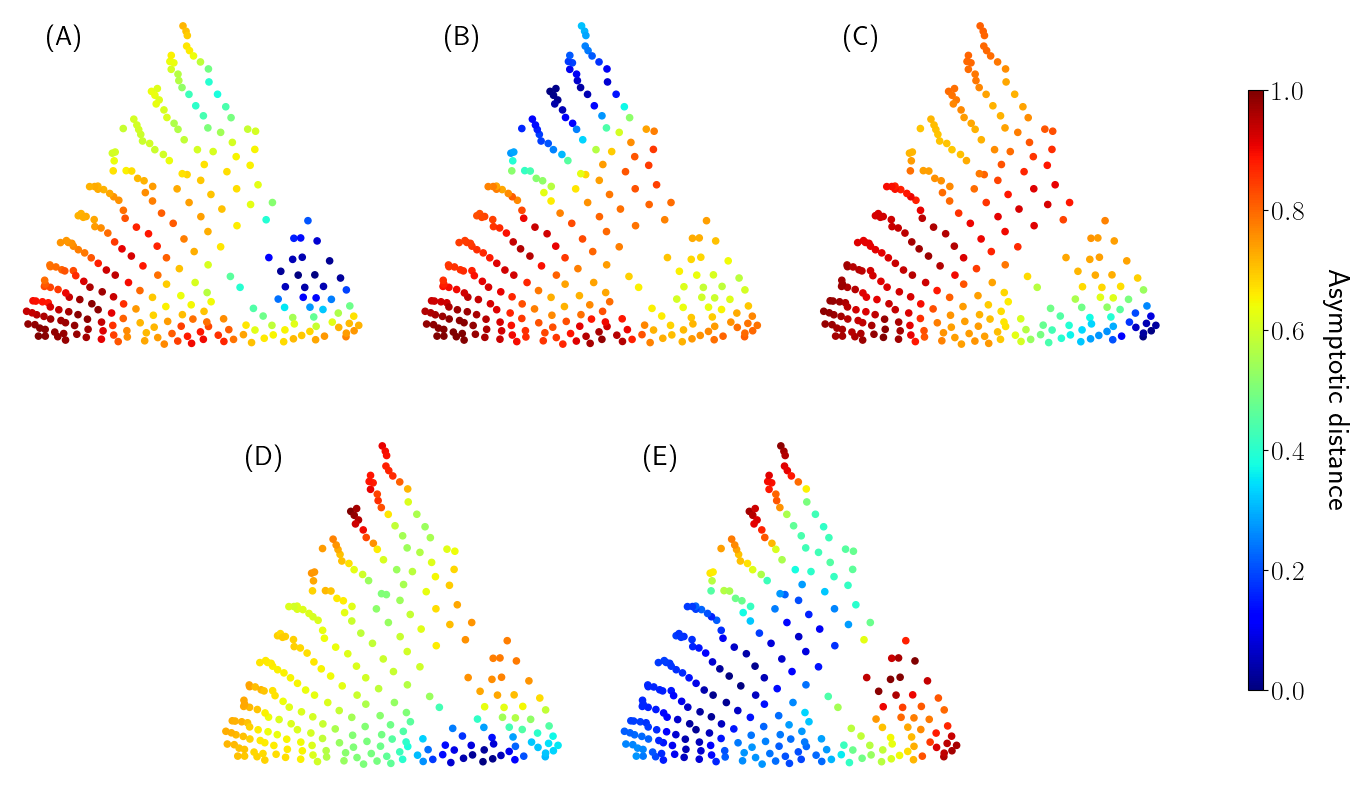

In [11]:
with plt.style.context(plt_style):
    fig, axs = setup_axs()
    for k, ax in enumerate(axs):
        cmap = cm.get_cmap('jet')
        ax.scatter(XYc[:,0], 
                   XYc[:,1],
                   c = result['dist'][:,k],
                   cmap=cmap,
                   s=20
                  )
        ax.axis('off')
        norm = Normalize(vmin=0, vmax = 1)
        mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    cax = plt.axes([0.95, 0.2, 0.01, 0.6])        
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.set_ylabel('Asymptotic distance', rotation=270, labelpad=32, fontsize=22)
    plt.show()